# 1. Data Collection and Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
from os.path import join
import sys
import warnings
warnings.filterwarnings(action='ignore')

import statsmodels
import math
from statsmodels.tsa.stattools import coint
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import *
from xgboost import XGBRegressor

path = '/content/drive/MyDrive/4-1/빅데이터경영'
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

## 코로나 데이터

**< 데이터 수집 >** 
* 출처 : 공공데이터포털

  
**< 데이터 설명 >** 
- 수집 원데이터 : 
    - 데이터 날짜 : 2020.02.05 - 2021.11.28 
    - 시/도별 코로나 발생 동향 중 서울특별시 데이터만 수집
- 전처리 후 : 
    - 데이터 날짜 : 2020.02.05 - 2021.09.30 
    - 과거 - 현재 순으로 데이터 정렬
    - 변수 선택 :  '서울시 기준일', '서울시 추가 확진', '서울시 추가 사망'
    - '서울시 확진자', '서울시 사망' 피처변수들이 누적값이므로 이를 이용해 각 날짜와 변수에 해당하는 '서울시 추가 확진', '서울시 추가 사망' 피처를 생성하였다.

### Data Load

In [ ]:
corona_file = '서울특별시 코로나19 확진자 발생동향.csv'
corona_path = join(path, corona_file)

raw_corona = pd.read_csv(corona_path, parse_dates=['서울시 기준일'], encoding='cp949')

### Data Preprocessing

1. 날짜 슬라이싱

매출 데이터가 2017.01.01 - 2021.09.30 인것을 감안하여 코로나 데이터의 날짜를 2021.09.30 까지의 데이터로 슬라이싱하였다.

In [ ]:
corona=raw_corona[53:]

날짜 데이터로 변환

In [ ]:
corona['서울시 기준일']=pd.to_datetime(corona['서울시 기준일']).dt.normalize()

2. 변수 선택

In [ ]:
corona=corona[['서울시 기준일','서울시 확진자','서울시 추가 확진','서울시 사망']]
corona.reset_index(drop=True, inplace=True)

In [ ]:
corona

,서울시 기준일,서울시 확진자,서울시 추가 확진,서울시 사망
0,2021-09-30,100495,945,643
1,2021-09-29,99550,1054,639
2,2021-09-28,98497,842,635
3,2021-09-27,97655,778,633
4,2021-09-26,96877,928,632
...,...,...,...,...
600,2020-02-09,10,0,0
601,2020-02-08,10,0,0
602,2020-02-07,10,0,0
603,2020-02-06,11,0,0


3. 데이터 날짜를 기준으로 오름차순 정렬

In [ ]:
corona=corona.loc[::-1,:]
corona

,서울시 기준일,서울시 확진자,서울시 추가 확진,서울시 사망
604,2020-02-05,8,0,0
603,2020-02-06,11,0,0
602,2020-02-07,10,0,0
601,2020-02-08,10,0,0
600,2020-02-09,10,0,0
...,...,...,...,...
4,2021-09-26,96877,928,632
3,2021-09-27,97655,778,633
2,2021-09-28,98497,842,635
1,2021-09-29,99550,1054,639


4. 중복값 제거

In [ ]:
corona.loc[[141, 142, 143], :]

,서울시 기준일,서울시 확진자,서울시 추가 확진,서울시 사망
141,2021-05-12,40118,223,466
142,2021-05-12,40118,223,466
143,2021-05-11,39895,163,464


In [ ]:
corona.drop(index = [142],inplace=True)
corona.reset_index(drop=True,inplace=True)

5. Feature Engineering

In [ ]:
corona['서울시 추가 사망']=0     #컬럼 생성

corona['서울시 추가 확진'][0]=corona['서울시 확진자'][0]
for i in range(603):
  corona['서울시 추가 확진'][i+1]=corona['서울시 확진자'][i+1]-corona['서울시 확진자'][i]
  corona['서울시 추가 사망'][i+1]=corona['서울시 사망'][i+1]-corona['서울시 사망'][i]

누적값을 기준으로 봤을 때 누적 확진자 수가 11명이었다가 10명으로 계속유지되는 것을 보면, 11명이 오타였을것으로 예상된다.   
따라서 음수값이 나온 추가 확진자수를 0으로 변경해주었다.

In [ ]:
corona['서울시 추가 확진'][2]=0  

# 사용하지 않는 피처 제거
corona.drop(['서울시 확진자','서울시 사망'],axis=1, inplace = True)

In [ ]:
corona.set_index('서울시 기준일', inplace = True)

In [ ]:
corona.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 604 entries, 2020-02-05 to 2021-09-30
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   서울시 추가 확진  604 non-null    int64
 1   서울시 추가 사망  604 non-null    int64
dtypes: int64(2)
memory usage: 14.2 KB


In [ ]:
corona.head()

,서울시 추가 확진,서울시 추가 사망
서울시 기준일,,
2020-02-05,8,0
2020-02-06,3,0
2020-02-07,0,0
2020-02-08,0,0
2020-02-09,0,0


# 날씨 데이터

* 출처 : 날씨마루

  
**< 데이터 설명 >** 
- 수집 원데이터 : 
  1. weather data
    - 데이터 날짜 : 2017년 - 2021년 년도별 데이터
    - 서울특별시의 날씨 데이터 (기온, 강수, 풍속 등)
  2. humidity data
    - 데이터 날짜 : 
      - humidity data 1 : 2017.01.01 - 2019.12.31
      - humidity data 2 : 2020.01.01 - 2021.09.30 
    - 서울특별시의 일자별 상대습도 데이터
  3. 부유분진 데이터
    - 데이터 날짜 : 2017년 - 2021년 년도별 데이터
    - 서울특별시의 미세먼지 농도 데이터

- 전처리 후 : 
    - 데이터 날짜 : 2017.01.01 - 2021.09.30 
    - 코로나 기준일(2020.02.05)를 기준으로 두 데이터셋으로 분리
    - 과거 - 현재 순으로 데이터 정렬
    - 년도별 수집한 데이터는 날짜별 데이터로 병합
    - 평균 날씨 데이터, 상대습도데이터, 평균 부유분진 농도 데이터를 병합
    - feature engineering 진행

### Data Load

기온/강수/풍속 데이터

In [ ]:
for i in range(2017, 2022):
  file_name = 'OBS_AWS_DD_' + str(i) + '.csv'
  file_path = join(path, file_name)
  dataframe_name = 'weather_' + str(i)
  vars()[dataframe_name] = pd.read_csv(file_path,encoding='cp949',parse_dates=['일시'] )

상대습도 데이터

In [ ]:
for i in range(1,3):
  file_name = 'OBS_ASOS_DD_humidity_' + str(i) + '.csv'
  file_path = join(path, file_name)
  dataframe_name = 'humidity_' + str(i)
  vars()[dataframe_name] = pd.read_csv(file_path,encoding='cp949',parse_dates=['일시'] )
  # 변수 선택
  vars()[dataframe_name]=vars()[dataframe_name][['일시','평균 상대습도(%)']]

부유분진 데이터

In [ ]:
for i in range(2017, 2022):
  file_name = 'OBS_부유분진_DD_' + str(i) + '.csv'
  file_path = join(path, file_name)
  dataframe_name = 'dust_' + str(i)
  vars()[dataframe_name] = pd.read_csv(file_path,encoding='cp949',parse_dates=['일시'] )

### Data Preprocessing

데이터 병합

In [ ]:
weather = pd.concat([weather_2017,weather_2018,weather_2019, weather_2020,weather_2021],axis=0)
weather = weather.groupby('일시').mean()
weather = weather.reset_index()
weather.drop(['지점','최저기온 시각(hhmi)','최고기온 시각(hhmi)','최대 순간 풍속(m/s)','최대 순간풍속 시각(hhmi)','최대 순간 풍속 풍향(deg)'],axis=1,inplace=True)

In [ ]:
dust = pd.concat([dust_2017,dust_2018,dust_2019,dust_2020,dust_2021],axis=0)
dust.drop(['지점','지점명'],axis=1,inplace=True)
dust.reset_index(drop=True, inplace = True)

In [ ]:
humidity = pd.concat([humidity_1, humidity_2],axis=0)
humidity.reset_index(drop=True, inplace = True)

In [ ]:
weather = pd.merge(weather,humidity,how='left',on='일시')
weather = pd.merge(weather,dust,how='left',on='일시')

Feature Engineering

In [ ]:
weather['불쾌지수'] = 1.8 * weather['평균기온(°C)'] - 0.55 * (1 - weather['평균 상대습도(%)']/100) * (1.8 * weather['평균기온(°C)'] - 26) + 32
weather['열지수']=0.5 * (1.8*weather['평균기온(°C)'] +32 + 61.0 + ((1.8*weather['평균기온(°C)']+32-68.0) * 1.2) + (weather['평균 상대습도(%)']/100*0.094))
weather['체감온도']=13.12+(0.6215*weather['평균기온(°C)'])-(11.37*(weather['평균 풍속(m/s)']**(0.16))) + 0.3965*weather['평균기온(°C)'] * (weather['평균 풍속(m/s)']**0.16)
weather

,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),평균 풍속(m/s),평균 상대습도(%),일 미세먼지 농도(㎍/㎥),불쾌지수,열지수,체감온도
0,2017-01-01,3.564286,-0.800000,7.525000,0.000000,0.953571,75.9,60.0,41.011611,31.992959,5.453892
1,2017-01-02,5.835714,2.728571,9.357143,0.071429,1.492857,77.8,90.0,44.396312,36.491280,7.091146
2,2017-01-03,2.792857,-1.100000,7.335714,0.000000,1.278571,61.8,65.0,41.433540,30.458903,4.181575
3,2017-01-04,4.489286,1.342857,9.160714,0.000000,1.192857,55.0,47.0,44.515738,33.814636,6.045646
4,2017-01-05,4.671429,0.185714,7.867857,0.000000,1.875000,52.3,30.0,45.023683,34.174010,5.498446
...,...,...,...,...,...,...,...,...,...,...,...
1729,2021-09-26,22.288462,18.115385,27.261538,0.000000,1.546154,63.0,10.0,69.245967,69.060764,24.256769
1730,2021-09-27,21.411538,18.503846,25.111538,0.000000,1.526923,66.0,14.0,68.195645,67.325866,23.345132
1731,2021-09-28,21.157692,19.257692,24.457692,2.423077,1.469231,75.1,14.0,68.428963,66.827528,23.099261
1732,2021-09-29,20.300000,17.846154,21.907692,10.307692,1.280769,93.5,19.0,68.163195,65.137945,22.281269


In [ ]:
weather.set_index('일시', inplace=True)
weather

,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),평균 풍속(m/s),평균 상대습도(%),일 미세먼지 농도(㎍/㎥),불쾌지수,열지수,체감온도
일시,,,,,,,,,,
2017-01-01,3.564286,-0.800000,7.525000,0.000000,0.953571,75.9,60.0,41.011611,31.992959,5.453892
2017-01-02,5.835714,2.728571,9.357143,0.071429,1.492857,77.8,90.0,44.396312,36.491280,7.091146
2017-01-03,2.792857,-1.100000,7.335714,0.000000,1.278571,61.8,65.0,41.433540,30.458903,4.181575
2017-01-04,4.489286,1.342857,9.160714,0.000000,1.192857,55.0,47.0,44.515738,33.814636,6.045646
2017-01-05,4.671429,0.185714,7.867857,0.000000,1.875000,52.3,30.0,45.023683,34.174010,5.498446
...,...,...,...,...,...,...,...,...,...,...
2021-09-26,22.288462,18.115385,27.261538,0.000000,1.546154,63.0,10.0,69.245967,69.060764,24.256769
2021-09-27,21.411538,18.503846,25.111538,0.000000,1.526923,66.0,14.0,68.195645,67.325866,23.345132
2021-09-28,21.157692,19.257692,24.457692,2.423077,1.469231,75.1,14.0,68.428963,66.827528,23.099261


In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1734 entries, 2017-01-01 to 2021-09-30
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   평균기온(°C)        1734 non-null   float64
 1   최저기온(°C)        1734 non-null   float64
 2   최고기온(°C)        1734 non-null   float64
 3   일강수량(mm)        1734 non-null   float64
 4   평균 풍속(m/s)      1734 non-null   float64
 5   평균 상대습도(%)      1734 non-null   float64
 6   일 미세먼지 농도(㎍/㎥)  1556 non-null   float64
 7   불쾌지수            1734 non-null   float64
 8   열지수             1734 non-null   float64
 9   체감온도            1734 non-null   float64
dtypes: float64(10)
memory usage: 149.0 KB


Treat Missing Values

In [ ]:
weather['일 미세먼지 농도(㎍/㎥)'].fillna(0, inplace = True)
for i in range(1094):
  if weather['일 미세먼지 농도(㎍/㎥)'][i] == 0:
    weather['일 미세먼지 농도(㎍/㎥)'][i]=(weather['일 미세먼지 농도(㎍/㎥)'][i-3]+weather['일 미세먼지 농도(㎍/㎥)'][i-2]+weather['일 미세먼지 농도(㎍/㎥)'][i-1])/3

데이터셋 분리

In [ ]:
weather_1 = weather.loc[slice('2017-01-01', '2020-02-04'), :]
weather_2 = weather.loc[slice('2020-02-05', '2021-09-30'), :]

In [ ]:
weather_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1130 entries, 2017-01-01 to 2020-02-04
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   평균기온(°C)        1130 non-null   float64
 1   최저기온(°C)        1130 non-null   float64
 2   최고기온(°C)        1130 non-null   float64
 3   일강수량(mm)        1130 non-null   float64
 4   평균 풍속(m/s)      1130 non-null   float64
 5   평균 상대습도(%)      1130 non-null   float64
 6   일 미세먼지 농도(㎍/㎥)  1130 non-null   float64
 7   불쾌지수            1130 non-null   float64
 8   열지수             1130 non-null   float64
 9   체감온도            1130 non-null   float64
dtypes: float64(10)
memory usage: 97.1 KB


In [ ]:
weather_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 604 entries, 2020-02-05 to 2021-09-30
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   평균기온(°C)        604 non-null    float64
 1   최저기온(°C)        604 non-null    float64
 2   최고기온(°C)        604 non-null    float64
 3   일강수량(mm)        604 non-null    float64
 4   평균 풍속(m/s)      604 non-null    float64
 5   평균 상대습도(%)      604 non-null    float64
 6   일 미세먼지 농도(㎍/㎥)  604 non-null    float64
 7   불쾌지수            604 non-null    float64
 8   열지수             604 non-null    float64
 9   체감온도            604 non-null    float64
dtypes: float64(10)
memory usage: 51.9 KB


## 매출 데이터

**< 데이터 수집 >** 
* 출처 : 서울시 빅데이터캠퍼스

  
**< 데이터 설명 >** 
- 원데이터 : 
    - 데이터 날짜 : 2017.01.01 - 2021.09.30 
    - 서울시 내의 세부 업종별(대분류, 중분류, 소분류) 카드 매출 건수 
- 전처리 후 : 
    - 데이터 날짜 : 2017.01.01 - 2021.09.30
    - 서울시 내의 대분류 업종들의 평균 카드 매출 건수 
    - 업종별 데이터셋으로 분리




In [ ]:
sales_file = 'sales.csv'

sales_path = join(path, sales_file)
raw_sales = pd.read_csv(sales_path, index_col = 0)
raw_sales.head()

,일시,성별,연령대별,SB_L_UPJONG_NM,SB_M_UPJONG_NM,SB_UPJONG_NM,counts_total
0,2017-01-01,F,10대,요식/유흥,한식,한식,5080.80
1,2017-01-01,F,20대,요식/유흥,한식,한식,91946.24
2,2017-01-01,F,30대,요식/유흥,한식,한식,66022.56
3,2017-01-01,F,40대,요식/유흥,한식,한식,65178.08
4,2017-01-01,F,50대,요식/유흥,한식,한식,47341.92


In [ ]:
raw_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458340 entries, 0 to 1458339
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   일시              1458340 non-null  object 
 1   성별              1458340 non-null  object 
 2   연령대별            1458340 non-null  object 
 3   SB_L_UPJONG_NM  1458340 non-null  object 
 4   SB_M_UPJONG_NM  1458340 non-null  object 
 5   SB_UPJONG_NM    1458340 non-null  object 
 6   counts_total    1458340 non-null  float64
dtypes: float64(1), object(6)
memory usage: 89.0+ MB


대분류 업종으로 테이블 생성



In [ ]:
grouped_sales =  raw_sales.groupby(by = ['일시', 'SB_L_UPJONG_NM']).mean()
grouped_sales.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 22139 entries, ('2017-01-01', '가전/가구') to ('2021-09-30', '주유')
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   counts_total  22139 non-null  float64
dtypes: float64(1)
memory usage: 251.4+ KB


In [ ]:
grouped_sales.reset_index(inplace = True)

In [ ]:
grouped_sales.일시 = pd.to_datetime(grouped_sales.일시)

In [ ]:
grouped_sales.set_index('일시', inplace=True)

In [ ]:
grouped_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22139 entries, 2017-01-01 to 2021-09-30
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SB_L_UPJONG_NM  22139 non-null  object 
 1   counts_total    22139 non-null  float64
dtypes: float64(1), object(1)
memory usage: 518.9+ KB


Treat Missing Values

데이터 수집 당시 2021년 1월 데이터가 존재하지 않았다.

따라서, 시계열 데이터임을 감안하여 ARIMA 방법을 이용해 2021.01.01 - 2021.01.31에 대한 예측값으로 대체한다.

Split data set
  - sales1 : 2017-01-01 to 2020-02-04
  - sales2 : 2020-02-05 to 2021-09-30

In [ ]:
def predict_jan(timeseries):
  arima_model = auto_arima(timeseries, start_P=0, d = 0, start_q = 0)
  jan_predict = arima_model.predict(n_periods=31)
  return jan_predict

In [ ]:
# 2021년 1월 예측 데이터셋 생성 및 코로나 기준 데이터셋 분리
sales1 = pd.DataFrame()
sales2 = pd.DataFrame()
upjong = list(raw_sales.SB_L_UPJONG_NM.unique())

for i, el in enumerate(upjong):
  temp = grouped_sales.loc[grouped_sales.SB_L_UPJONG_NM == el, :]
  temp = temp.resample('D')
  temp = temp.first()

  temp.loc['2021-01-01':'2021-01-31', 'SB_L_UPJONG_NM'] = [el]*31

  timeseries = temp.loc['2017-01-01': '2020-12-31', 'counts_total']
  jan_pred = predict_jan(timeseries)
  temp.loc['2021-01-01':'2021-01-31', 'counts_total'] = jan_pred

  temp1 = temp.loc[:'2020-02-04', :]
  temp2 = temp.loc['2020-02-05' :, :]

  sales1 = pd.concat([sales1, temp1])
  sales2 = pd.concat([sales2, temp2])

# 2. EDA

### 1. 상관관계 파악 등
### 2. 공적분 관계 파악 후 업종 선택 

In [ ]:
sales1['SB_L_UPJONG_NM'].unique()

array(['요식/유흥', '유통', '음/식료품', '의류/잡화', '스포츠/문화/레저', '여행/교통', '미용',
       '가정생활/서비스', '교육/학원', '의료', '가전/가구', '자동차', '주유'], dtype=object)

In [ ]:
weather_values_1 = weather_1.columns
upjong = sales1['SB_L_UPJONG_NM'].unique()

for j in range(len(weather_values_1)):
  vars()['upjong_' + str(j)] = {weather_values_1[j] : []}

  for i in range(len(upjong)):
    A = sales1[sales1['SB_L_UPJONG_NM'] == upjong[i]]
    score, p_value, _ = coint(A['counts_total'],weather_1[weather_values_1[j]])

    if p_value < 0.05:
       vars()['upjong_' + str(j)][weather_values_1[j]].append(upjong[i])

In [ ]:
intersection = list(set(list(upjong_0.values())[0]) & set(list(upjong_1.values())[0]) & set(list(upjong_2.values())[0])& set(list(upjong_3.values())[0])& set(list(upjong_4.values())[0])& set(list(upjong_5.values())[0])& set(list(upjong_6.values())[0])& set(list(upjong_7.values())[0])& set(list(upjong_8.values())[0])& set(list(upjong_9.values())[0]))

In [ ]:
intersection

['가전/가구', '주유', '가정생활/서비스', '요식/유흥', '의료', '교육/학원']

# 3. Analyze

장기 예측을 위해 공적분 관계를 이용한다.

코로나19 발생 이전 날씨와 공적분 관계인 업종들 중 코로나19 발생 이후 날씨와 공적분 관계가 유의하지 않은 업종을 선택한다.  
코로나 발생 이후 날씨의 영향보다 제 3의 factor의 영향을 받았던 것으로 예상되는 업종을 선발하는 것이다.

In [ ]:
weather_values_2 = weather_2.columns
vote = {}
select = {}

for up_sales in intersection:
  vote[up_sales] = {}
  for weather_c in weather_values_2:
    sales_upjong = sales2.loc[sales2['SB_L_UPJONG_NM'] == up_sales, 'counts_total']
    score, p_value, _ = coint(sales_upjong, weather_2[weather_c])
    vote[up_sales][weather_c] = p_value
  

for key, value in vote.items():
  select[key] = []
  for k, v in value.items():
    if v > 0.05:
       select[key].append(k)

select

{'가전/가구': ['평균기온(°C)',
  '최저기온(°C)',
  '최고기온(°C)',
  '일강수량(mm)',
  '평균 풍속(m/s)',
  '평균 상대습도(%)',
  '일 미세먼지 농도(㎍/㎥)',
  '불쾌지수',
  '열지수',
  '체감온도'],
 '가정생활/서비스': [],
 '교육/학원': [],
 '요식/유흥': ['일강수량(mm)', '평균 상대습도(%)', '일 미세먼지 농도(㎍/㎥)'],
 '의료': ['평균 상대습도(%)'],
 '주유': ['평균기온(°C)',
  '최저기온(°C)',
  '최고기온(°C)',
  '일강수량(mm)',
  '평균 풍속(m/s)',
  '평균 상대습도(%)',
  '일 미세먼지 농도(㎍/㎥)',
  '불쾌지수',
  '열지수',
  '체감온도']}

여기서 날씨 데이터의 모든 변수들과 공적분 관계가 아닌 업종을 선택한다.

코로나 데이터와 공적분 관계 확인

In [ ]:
corona_values = corona.columns
refuel = sales2.loc[sales2['SB_L_UPJONG_NM'] == '주유']

for i in corona_values:
  score, p_value, _ = coint(refuel['counts_total'],corona[i])
  print(i)
  print(p_value)

서울시 추가 확진
0.04698357227667916
서울시 추가 사망
0.1659903532464876


In [ ]:
corona_values = corona.columns
furniture = sales2.loc[sales2['SB_L_UPJONG_NM'] == '가전/가구']

for i in corona_values:
  score, p_value, _ = coint(furniture['counts_total'],corona[i])
  print(i)
  print(p_value)

서울시 추가 확진
0.07188446005279775
서울시 추가 사망
0.4521014548247985


모든 코로나 데이터의 변수와 공적분 관계가 없는 가전/가구 업종이 아닌 주유 업종을 선택하여 분석을 진행한다.

날씨 이외의 변수와의 관계를 보기위해 주유업종과 다른 업종의 매출 데이터간 공적분 관계를 확인한다.

In [ ]:
refuel = sales2.loc[sales2['SB_L_UPJONG_NM'] == '주유']

In [ ]:
def coint_with_refuel(upjong_name):
  temp = sales2.loc[sales2['SB_L_UPJONG_NM'] == upjong_name, 'counts_total']
  score, p_value, _ = coint(refuel['counts_total'], temp)

  return p_value

In [ ]:
others = list(sales2['SB_L_UPJONG_NM'].unique())
others.remove('주유')

others

['요식/유흥',
 '유통',
 '음/식료품',
 '의류/잡화',
 '스포츠/문화/레저',
 '여행/교통',
 '미용',
 '가정생활/서비스',
 '교육/학원',
 '의료',
 '가전/가구',
 '자동차']

In [ ]:
refuel_coint_results = {}

for i, upjong in enumerate(others):
  coint_res = coint_with_refuel(upjong)
  refuel_coint_results[upjong] = coint_res

In [ ]:
select_feature = []
for k, v in refuel_coint_results.items():
  if v < 0.05 :
    select_feature.append(k)

In [ ]:
select_feature

['음/식료품', '가전/가구']

Overall data set to run model

In [ ]:
pd.DataFrame({'가전/가구' : sales2.loc[sales2['SB_L_UPJONG_NM'] =='가전/가구', 'counts_total']})

,가전/가구
일시,
2020-02-05,674.586585
2020-02-06,677.859512
2020-02-07,689.132927
2020-02-08,597.490976
2020-02-09,396.024146
...,...
2021-09-26,821.165714
2021-09-27,1236.244390
2021-09-28,1209.593000


In [ ]:
refuel.drop(columns=['SB_L_UPJONG_NM'], inplace = True)
all_df = refuel.rename(columns = {'counts_total' : 'refuel'})

for f in select_feature:
  temp = pd.DataFrame({f : sales2.loc[sales2['SB_L_UPJONG_NM'] == f, 'counts_total']})
  all_df = pd.merge(all_df, temp, left_index=True, right_index=True)

In [ ]:
all_df = pd.merge(all_df, corona, left_index=True, right_index=True)
all_df

,refuel,음/식료품,가전/가구,서울시 추가 확진,서울시 추가 사망
일시,,,,,
2020-02-05,7103.418519,6616.726667,674.586585,8,0
2020-02-06,7374.191481,7142.955000,677.859512,3,0
2020-02-07,7594.160000,8722.468333,689.132927,0,0
2020-02-08,7659.835000,8145.593333,597.490976,0,0
2020-02-09,6582.120741,5438.836667,396.024146,0,0
...,...,...,...,...,...
2021-09-26,6737.570714,8618.384762,821.165714,928,2
2021-09-27,6749.859286,10448.659048,1236.244390,778,1
2021-09-28,7005.663704,10159.877619,1209.593000,842,2


### Train Test Data Split

시계열 데이터의 양이 적다고 판단된다.
따라서 학습 데이터와 테스트 데이터의 비율을 약 9:1로 나눈다.

In [ ]:
n = len(all_df)
m = list(range(0,n))[-62:]

all_df_int_idx = all_df.reset_index()
train = all_df_int_idx.loc[:m[0], :]
train.set_index('일시', inplace=True)
test = all_df_int_idx.loc[m[0]+1 : m[-1] + 1, :]
test.set_index('일시', inplace=True)

print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 543 entries, 2020-02-05 to 2021-07-31
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   refuel     543 non-null    float64
 1   음/식료품      543 non-null    float64
 2   가전/가구      543 non-null    float64
 3   서울시 추가 확진  543 non-null    int64  
 4   서울시 추가 사망  543 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 25.5 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2021-08-01 to 2021-09-30
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   refuel     61 non-null     float64
 1   음/식료품      61 non-null     float64
 2   가전/가구      61 non-null     float64
 3   서울시 추가 확진  61 non-null     int64  
 4   서울시 추가 사망  61 non-null     int64  
dtypes: float64(3), int64(2)
memory usage: 2.9 KB
None


## 그레인저 인과관계

한 변수의 과거 값이 다른 변수의 미래값에 예측이 도움이 되는가?

- 비정상 시계열 데이터 여부 확인

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root.

In [ ]:
diff_df = pd.DataFrame()

In [ ]:
for c in list(all_df.columns):
  result = adfuller(train[c])
  if result[1] < 0.05:
    print('stationary')
    temp = pd.DataFrame({c : train[c][1:]})
    diff_df = pd.concat([diff_df, temp], axis = 1)
  else:
    print('non stationary. So, need to difference')
    diff_col = train.loc[:, c].diff().dropna()
    result = adfuller(diff_col)
    if result[1] < 0.05:
      print('stationary')
      temp = pd.DataFrame({c+'_diff' : diff_col})
      diff_df = pd.concat([diff_df, temp], axis = 1)
    else:
      print('non stationary')


non stationary. So, need to difference
stationary
stationary
non stationary. So, need to difference
stationary
non stationary. So, need to difference
stationary
non stationary. So, need to difference
stationary


In [ ]:
diff_df

,refuel_diff,음/식료품,가전/가구_diff,서울시 추가 확진_diff,서울시 추가 사망_diff
일시,,,,,
2020-02-06,270.772963,7142.955000,3.272927,-5.0,0.0
2020-02-07,219.968519,8722.468333,11.273415,-3.0,0.0
2020-02-08,65.675000,8145.593333,-91.641951,0.0,0.0
2020-02-09,-1077.714259,5438.836667,-201.466829,0.0,0.0
2020-02-10,303.906296,7273.003333,330.187520,0.0,0.0
...,...,...,...,...,...
2021-07-27,-236.629563,10104.311905,-55.934798,10.0,0.0
2021-07-28,316.736971,10029.939762,-20.055591,222.0,2.0
2021-07-29,196.542593,10084.670952,-43.052944,-58.0,-1.0


그레인저 인과관계

Granger Causality tests try to determine if one variable(x1) can be used as a predictor of another variable(x2) where the past values of that another variable may or may not help. 

This means that x1 explains beyond the past values of x2.

Two important assumptions here are -
1. both x1 and x2 are stationary
2. there exists a linear relation between their current and past values.


This means that if x1 and x2 are non-stationary, we have to make them stationary before testing for Granger Causality.

In [ ]:
# 음/식료품 -> 주유
grangercausalitytests(diff_df[['refuel_diff', '음/식료품']], maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=57.5997 , p=0.0000  , df_denom=538, df_num=1
ssr based chi2 test:   chi2=57.9209 , p=0.0000  , df=1
likelihood ratio test: chi2=55.0253 , p=0.0000  , df=1
parameter F test:         F=57.5997 , p=0.0000  , df_denom=538, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=18.4668 , p=0.0000  , df_denom=535, df_num=2
ssr based chi2 test:   chi2=37.2787 , p=0.0000  , df=2
likelihood ratio test: chi2=36.0483 , p=0.0000  , df=2
parameter F test:         F=18.4668 , p=0.0000  , df_denom=535, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=11.8549 , p=0.0000  , df_denom=532, df_num=3
ssr based chi2 test:   chi2=36.0328 , p=0.0000  , df=3
likelihood ratio test: chi2=34.8795 , p=0.0000  , df=3
parameter F test:         F=11.8549 , p=0.0000  , df_denom=532, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.9637  , p=0.0000  

{1: ({'lrtest': (55.025277378932515, 1.189896469913356e-13, 1),
   'params_ftest': (57.59974314158463, 1.4258447763849544e-13, 538.0, 1.0),
   'ssr_chi2test': (57.92093130036697, 2.7286813773668614e-14, 1),
   'ssr_ftest': (57.5997431415849, 1.4258447763848176e-13, 538.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (36.048298374738806, 1.4866593511237278e-08, 2),
   'params_ftest': (18.466786923288133, 1.7566732593623478e-08, 535.0, 2.0),
   'ssr_chi2test': (37.278747433927414, 8.035683974683415e-09, 2),
   'ssr_ftest': (18.466786923288115, 1.7566732593623478e-08, 535.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (34.87949208516693, 1.2917988949696153e-07, 3),
   'params_ftest': (11.85494271353653, 1.5851861002821843e-07, 532.0, 3.0),
   'ssr_chi2test': (36.032786405617706, 7.369800576650826e-08, 3),
   'ssr_ftest': (11.85494271353656, 1.585186100282145e-07, 532.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0.,

In [ ]:
# 음/식료품 -> 주유
grangercausalitytests(diff_df[['refuel_diff', '가전/가구_diff']], maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=64.4914 , p=0.0000  , df_denom=538, df_num=1
ssr based chi2 test:   chi2=64.8510 , p=0.0000  , df=1
likelihood ratio test: chi2=61.2493 , p=0.0000  , df=1
parameter F test:         F=64.4914 , p=0.0000  , df_denom=538, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=14.8869 , p=0.0000  , df_denom=535, df_num=2
ssr based chi2 test:   chi2=30.0520 , p=0.0000  , df=2
likelihood ratio test: chi2=29.2456 , p=0.0000  , df=2
parameter F test:         F=14.8869 , p=0.0000  , df_denom=535, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.3455  , p=0.0001  , df_denom=532, df_num=3
ssr based chi2 test:   chi2=22.3266 , p=0.0001  , df=3
likelihood ratio test: chi2=21.8766 , p=0.0001  , df=3
parameter F test:         F=7.3455  , p=0.0001  , df_denom=532, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=21.8527 , p=0.0000  

{1: ({'lrtest': (61.249250734352245, 5.028769559222904e-15, 1),
   'params_ftest': (64.49143010486367, 6.148225373312567e-15, 538.0, 1.0),
   'ssr_chi2test': (64.85104774485366, 8.077911620060323e-16, 1),
   'ssr_ftest': (64.49143010486371, 6.14822537331213e-15, 538.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (29.245597526858546, 4.460660670805518e-07, 2),
   'params_ftest': (14.886889787067135, 5.107413809958418e-07, 535.0, 2.0),
   'ssr_chi2test': (30.052039196322323, 2.9804552365622624e-07, 2),
   'ssr_ftest': (14.886889787067076, 5.10741380995889e-07, 535.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (21.876576098258738, 6.920426753809623e-05, 3),
   'params_ftest': (7.345548014294079, 7.852669767890215e-05, 532.0, 3.0),
   'ssr_chi2test': (22.326599885551694, 5.5780034020933875e-05, 3),
   'ssr_ftest': (7.345548014294064, 7.852669767890215e-05, 532.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0

In [ ]:
# 서울시 추가 확진_diff -> 주유
grangercausalitytests(diff_df[['refuel_diff', '서울시 추가 확진_diff']], maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2372  , p=0.2665  , df_denom=538, df_num=1
ssr based chi2 test:   chi2=1.2441  , p=0.2647  , df=1
likelihood ratio test: chi2=1.2427  , p=0.2650  , df=1
parameter F test:         F=1.2372  , p=0.2665  , df_denom=538, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2027  , p=0.3012  , df_denom=535, df_num=2
ssr based chi2 test:   chi2=2.4279  , p=0.2970  , df=2
likelihood ratio test: chi2=2.4225  , p=0.2978  , df=2
parameter F test:         F=1.2027  , p=0.3012  , df_denom=535, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.5113  , p=0.0001  , df_denom=532, df_num=3
ssr based chi2 test:   chi2=22.8303 , p=0.0000  , df=3
likelihood ratio test: chi2=22.3600 , p=0.0001  , df=3
parameter F test:         F=7.5113  , p=0.0001  , df_denom=532, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=8.2148  , p=0.0000  

{1: ({'lrtest': (1.242655573420052, 0.26495987320189324, 1),
   'params_ftest': (1.2371850307921115, 0.266511023475801, 538.0, 1.0),
   'ssr_chi2test': (1.2440838320791465, 0.26468544892231904, 1),
   'ssr_ftest': (1.2371850307922012, 0.266511023475801, 538.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (2.422486705818301, 0.2978267453750398, 2),
   'params_ftest': (1.2027238812927687, 0.30118573742667304, 535.0, 2.0),
   'ssr_chi2test': (2.4279285827966697, 0.2970174786022797, 2),
   'ssr_ftest': (1.2027238812927947, 0.30118573742667754, 535.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (22.360011790551653, 5.489368985495331e-05, 3),
   'params_ftest': (7.511263066527191, 6.246970265763856e-05, 532.0, 3.0),
   'ssr_chi2test': (22.83028642589199, 4.38094854521502e-05, 3),
   'ssr_ftest': (7.511263066527235, 6.246970265763302e-05, 532.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 

In [ ]:
# 서울시 추가 사망_diff -> 주유
grangercausalitytests(diff_df[['refuel_diff', '서울시 추가 사망_diff']], maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0509  , p=0.8217  , df_denom=538, df_num=1
ssr based chi2 test:   chi2=0.0511  , p=0.8211  , df=1
likelihood ratio test: chi2=0.0511  , p=0.8211  , df=1
parameter F test:         F=0.0509  , p=0.8217  , df_denom=538, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1957  , p=0.8223  , df_denom=535, df_num=2
ssr based chi2 test:   chi2=0.3951  , p=0.8207  , df=2
likelihood ratio test: chi2=0.3949  , p=0.8208  , df=2
parameter F test:         F=0.1957  , p=0.8223  , df_denom=535, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2349  , p=0.8721  , df_denom=532, df_num=3
ssr based chi2 test:   chi2=0.7139  , p=0.8699  , df=3
likelihood ratio test: chi2=0.7134  , p=0.8700  , df=3
parameter F test:         F=0.2349  , p=0.8721  , df_denom=532, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7656  , p=0.5480  

{1: ({'lrtest': (0.05114142039747094, 0.8210888878994466, 1),
   'params_ftest': (0.05086023047028148, 0.821658753833015, 538.0, 1.0),
   'ssr_chi2test': (0.05114383770336852, 0.8210847312378234, 1),
   'ssr_ftest': (0.05086023047026296, 0.8216587538331179, 538.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (0.3949357316196256, 0.8208065161566415, 2),
   'params_ftest': (0.19571101876761496, 0.8223086566942559, 535.0, 2.0),
   'ssr_chi2test': (0.39508018741875695, 0.8207472331669983, 2),
   'ssr_ftest': (0.19571101876762498, 0.8223086566942559, 535.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (0.713404957567036, 0.8700465301380257, 3),
   'params_ftest': (0.23486871783784072, 0.8720740925661292, 532.0, 3.0),
   'ssr_chi2test': (0.7138772871125146, 0.8699351186671866, 3),
   'ssr_ftest': (0.23486871783788363, 0.8720740925661014, 532.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0

유의수준 0.05 이하에서 서울시 추가 사망 데이터는 주유 데이터와 그레인저 인과관계가 없다고 할 수 있다.

명확한 분석을 위해 서울시 추가 사망 변수는 제거하기로 한다.

In [ ]:
train.drop(columns=['서울시 추가 사망'], inplace = True)
test.drop(columns=['서울시 추가 사망'], inplace = True)

# VECM Model

### VECM Parameters

In [ ]:
lag_order = select_order(data=train, maxlags=5, deterministic="ci")
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,43.38,43.58,6.943e+18,43.46
1,42.96,43.28,4.535e+18,43.08
2,42.81,43.26,3.927e+18,42.99
3,42.73,43.31,3.618e+18,42.96
4,42.67,43.37,3.404e+18,42.95
5,42.21*,43.04*,2.145e+18*,42.53*


2. Cointegration Rank

In [ ]:
rank_test = select_coint_rank(train, 0, 3, method="trace", signif=0.05)
rank_test.rank

3

In [ ]:
rank_test.summary()

r_0,r_1,test statistic,critical value
0,4,260.4,47.85
1,4,92.72,29.80
2,4,27.17,15.49
3,4,0.2124,3.841


### Model fitting

In [ ]:
model = VECM(train, deterministic="ci", 
             k_ar_diff=lag_order.aic,  
             coint_rank=rank_test.rank)  

In [ ]:
vecm_fit = model.fit()

In [ ]:
vecm_fit.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.refuel,-0.3748,0.076,-4.957,0.000,-0.523,-0.227
L1.음/식료품,0.0286,0.030,0.962,0.336,-0.030,0.087
L1.가전/가구,0.0758,0.312,0.243,0.808,-0.536,0.687
L1.서울시 추가 확진,-0.9787,0.563,-1.737,0.082,-2.083,0.126
L2.refuel,-0.3852,0.070,-5.535,0.000,-0.522,-0.249
L2.음/식료품,0.0411,0.029,1.427,0.154,-0.015,0.098
L2.가전/가구,0.2594,0.301,0.863,0.388,-0.330,0.848
L2.서울시 추가 확진,-0.9831,0.612,-1.606,0.108,-2.183,0.217
L3.refuel,-0.2738,0.064,-4.292,0.000,-0.399,-0.149
L3.음/식료품,-0.0317,0.028,-1.149,0.250,-0.086,0.022


### Predict

In [ ]:
vecm_pred, lower, upper = vecm_fit.predict(61, 0.05)
rmse = math.sqrt(mean_squared_error(test.refuel, vecm_pred[:,0]))
rmse

777.2186278502463

# Usage of Machine Learning Model

변수들의 scale 에 로버스트한 트리계열의 모델로 XGBoostRegressor를 이용하기로 한다.

In [ ]:
x_train = train[['음/식료품', '가전/가구', '서울시 추가 확진']]
y_train = train['refuel']

x_test = test[['음/식료품', '가전/가구', '서울시 추가 확진']]
y_test = test['refuel']

### Model fitting

In [ ]:
xgbr = XGBRegressor()
xgbr.fit(x_train, y_train)

[12:09:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

### Predict

In [ ]:
xgbr_pred = xgbr.predict(x_test)
xgbr_rmse = math.sqrt(mean_squared_error(xgbr_pred, y_test))
xgbr_rmse

574.0836852237642

위의 수치적 결과가 아쉬운 부분은 분명 존재하지만 모든 데이터분석 절차와 결과를 정리 및 해석하고 인사이트 도출까지의 과정을 실현시키는 것에 더 중요점을 두었다.
또한 이 수치적 결과가 아쉬웠던 것은 데이터 수집에 대한 한계가 분명히 존재하였고 코로나라는 특정 시기의 데이터를 이용하려다 보니 시계열 분석에있어서 1년 9개월이라는 짧은 기간의 데이터가 아쉬웠다.
그리고 가장 큰 것은 아래에서도 알 수 있지만, 피쳐스케일링의 차이였다고 생각한다.
VECM에 대해서 지식이 부족하여 섣부르게 피쳐스케일링을 하는게 맞지 않을 수도 있겠다라는 생각에 진행을 하지않고 정리하였지만,실제로 스케일링을 했을 때 예측값이 훨씬 더 좋았다. minmaxscaling을 통해 진행을 하면 추세가 모두 없어진다고 생각이 들어 올바르지 않다고 판단하였다.


# LSTM

참고 :https://dschloe.github.io/python/python_edu/07_deeplearning/deep_learning_lstm/

In [ ]:
from sklearn.preprocessing import MinMaxScaler

all_df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = list(all_df.columns)

df_scaled = scaler.fit_transform(all_df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,refuel,음/식료품,가전/가구,서울시 추가 확진,서울시 추가 사망
0,0.483657,0.130598,0.410525,0.006552,0.000000
1,0.544516,0.160032,0.413705,0.002457,0.000000
2,0.593956,0.248379,0.424657,0.000000,0.000000
3,0.608717,0.216113,0.335625,0.000000,0.000000
4,0.366490,0.064715,0.139897,0.000000,0.000000
...,...,...,...,...,...
599,0.401429,0.242558,0.552929,0.760033,0.181818
600,0.404191,0.344931,0.956184,0.637183,0.090909
601,0.461686,0.328778,0.930292,0.689599,0.181818
602,0.371413,0.297848,0.890227,0.862408,0.363636


In [ ]:
TEST_SIZE = 61
WINDOW_SIZE = 20

train_feature = df_scaled[:-TEST_SIZE]
train_label = df_scaled[['refuel']][:-TEST_SIZE]
test_feature = df_scaled[-TEST_SIZE:]
test_label = df_scaled[['refuel']][-TEST_SIZE:]

In [ ]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
train_feature, train_label = make_dataset(train_feature, train_label, 20)
test_feature, test_label = make_dataset(test_feature, test_label, 20)

print(train_feature.shape, train_label.shape)

(523, 20, 5) (523, 1)


In [ ]:
train_feature = train_feature[:462,:,:]
train_label = train_label[:462:, :]
val_feature = train_feature[-61:,:,:]
val_label = train_label[-61:,:]

In [ ]:
print(train_feature.shape, train_label.shape)
print(val_feature.shape, val_label.shape)
print(test_feature.shape, test_label.shape)

(462, 20, 5) (462, 1)
(61, 20, 5) (61, 1)
(41, 20, 5) (41, 1)


- Model training

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = join(path, model_path, 'tmp_checkpoint.h5')

checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(train_feature, train_label, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(val_feature, val_label),
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
28/29 [===========================>..] - ETA: 0s - loss: 0.1763
Epoch 00001: val_loss improved from inf to 0.13537, saving model to /content/drive/MyDrive/4-1/빅데이터경영/model/tmp_checkpoint.h5
29/29 [==============================] - 2s 26ms/step - loss: 0.1759 - val_loss: 0.1354
Epoch 2/200
29/29 [==============================] - ETA: 0s - loss: 0.0642
Epoch 00002: val_loss improved from 0.13537 to 0.01558, saving model to /content/drive/MyDrive/4-1/빅데이터경영/model/tmp_checkpoint.h5
29/29 [==============================] - 0s 8ms/step - loss: 0.0642 - val_loss: 0.0156
Epoch 3/200
26/29 [=========================>....] - ETA: 0s - loss: 0.0238
Epoch 00003: val_loss improved from 0.01558 to 0.01531, saving model to /content/drive/MyDrive/4-1/빅데이터경영/model/tmp_checkpoint.h5
29/29 [==============================] - 0s 9ms/step - loss: 0.0236 - val_loss: 0.0153
Epoch 4/200
28/29 [===========================>..] - ETA: 0s - loss: 0.0194
Epoch 00004: val_loss

In [ ]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

(41, 1)

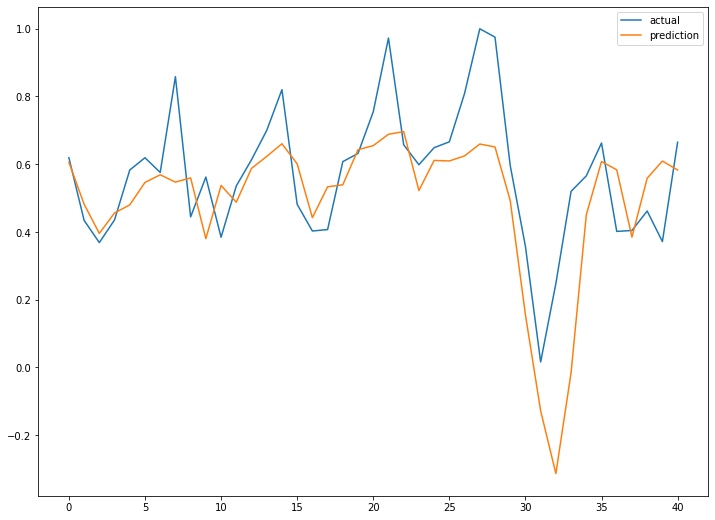

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

위에서 말한대로 피쳐스케일링을 진행 후 했을 때의 모습이다. 예측력이 굉장히 좋은 것을 알 수 있다.